# Correspondence Autoencoder Sequence-to-Sequence Model for Speech

Herman Kamper, Stellenbosch University, 2018-2019.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes


In [3]:
class SimpleIterator(object):
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [4]:
class SimpleBucketIterator(object):
    
    def __init__(self, x_list, batch_size, n_buckets, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [5]:
def get_pair_list(labels):
    """Return a list of tuples giving indices of matching types."""
    N = len(labels)
    match_list = []
    for n in range(N - 1):
        cur_label = labels[n]
        for cur_match_i in n + 1 + np.where(np.asarray(labels[n + 1:]) == cur_label)[0]:
            match_list.append((n, cur_match_i))
            match_list.append((cur_match_i, n))
    return match_list


class PairedSimpleIterator(object):
    
    def __init__(self, x_list, pair_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.pair_list = pair_list
#         self.indices = np.arange(len(self.pair_list))
        np.random.shuffle(self.pair_list)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.pair_list)
        
        for i_batch in xrange(self.n_batches):

            batch_indices_a = [i for i, j in self.pair_list[i_batch*self.batch_size:(i_batch + 1)*self.batch_size]]
            batch_indices_b = [j for i, j in self.pair_list[i_batch*self.batch_size:(i_batch + 1)*self.batch_size]]
            
#             print(batch_indices_a, batch_indices_b)
            
            batch_lengths_a = self.x_lengths[batch_indices_a]
            batch_lengths_b = self.x_lengths[batch_indices_b]
            
            n_pad = max(np.max(batch_lengths_a), np.max(batch_lengths_b))
            
            # Pad to maximum length in batch            
            batch_padded_a = np.zeros((len(batch_indices_a), n_pad, self.n_input), dtype=NP_DTYPE)
            batch_padded_b = np.zeros((len(batch_indices_b), n_pad, self.n_input), dtype=NP_DTYPE)
            for i, length in enumerate(batch_lengths_a):
                seq = self.x_list[batch_indices_a[i]]
                batch_padded_a[i, :length, :] = seq
            for i, length in enumerate(batch_lengths_b):
                seq = self.x_list[batch_indices_b[i]]
                batch_padded_b[i, :length, :] = seq
            
            yield (batch_padded_a, batch_lengths_a, batch_padded_b, batch_lengths_b)


In [6]:
class PairedBucketIterator(object):
    
    def __init__(self, x_list, pair_list, batch_size, n_buckets, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.pair_list = pair_list
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([max(len(x_list[i]), len(x_list[j])) for i, j in pair_list])
#         print("lengths:", [len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()

    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)

#         print([max(len(x_list[i]), len(x_list[j])) for i, j in pair_list])
#         print(sorted_indices)
#         return
        
        
#         self.indices = np.arange(len(self.pair_list))
#         np.random.shuffle(self.pair_list)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):
            
            batch_pair_list = [
                self.pair_list[i] for i in self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size]
                ]
#             print("batch_pair_list", batch_pair_list)

            batch_indices_a = [i for i, j in batch_pair_list]
            batch_indices_b = [j for i, j in batch_pair_list]
            
#             print(batch_indices_a, batch_indices_b)
            
            batch_lengths_a = self.x_lengths[batch_indices_a]
            batch_lengths_b = self.x_lengths[batch_indices_b]
            
            n_pad = max(np.max(batch_lengths_a), np.max(batch_lengths_b))
            
            # Pad to maximum length in batch            
            batch_padded_a = np.zeros((len(batch_indices_a), n_pad, self.n_input), dtype=NP_DTYPE)
            batch_padded_b = np.zeros((len(batch_indices_b), n_pad, self.n_input), dtype=NP_DTYPE)
            for i, length in enumerate(batch_lengths_a):
                seq = self.x_list[batch_indices_a[i]]
                batch_padded_a[i, :length, :] = seq
            for i, length in enumerate(batch_lengths_b):
                seq = self.x_list[batch_indices_b[i]]
                batch_padded_b[i, :length, :] = seq
            
            yield (batch_padded_a, batch_lengths_a, batch_padded_b, batch_lengths_b)

In [7]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1_utd_terms.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12021
E.g. item shape: (62, 39)


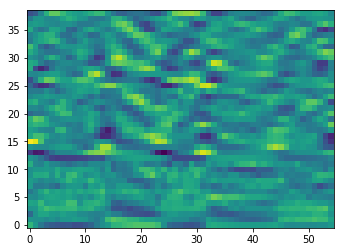

In [8]:
plt.imshow(train_x[3277].T, origin="bottom");

In [9]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [10]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

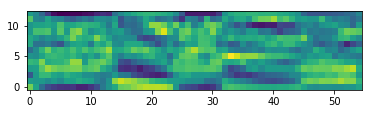

In [11]:
plt.imshow(train_x[3277].T, origin="bottom");

## Multi-layer sequence-to-sequence model with latent CAE representation

In [12]:
# Autoencoder pretraining

tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 100  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = get_pair_list(train_labels)

# Model parameters
n_input = d_frame
enc_n_hiddens = [400, 400, 400]
dec_n_hiddens = [400, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
pretrain_intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.tmp.ckpt")
pretrain_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.ckpt")
intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.tmp.ckpt")
model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.ckpt")

# Model
a = tf.placeholder(TF_DTYPE, [None, None, n_input])
a_lengths = tf.placeholder(TF_ITYPE, [None])
b = tf.placeholder(TF_DTYPE, [None, None, n_input])
b_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_multi_encdec_lazydynamic_latentfunc(
    a, a_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, y_lengths=b_lengths, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
ae = network_dict["latent_layer"]
z = ae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(b - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [13]:
def samediff_val():
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = SimpleIterator(
        val_x, len(val_x), False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
                )[0]
#             np_y = session.run(
#                 [y], feed_dict={a: np_x, a_lengths: np_x_lengths, b_lengths: np_x_lengths}
#                 )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

#     np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
#     distances = pdist(np_z_normalised, metric="cosine")
#     matches = samediff.generate_matches_array(labels)
#     ap, prb = samediff.average_precision(
#         distances[matches == True], distances[matches == False]
#         )
        
    # Same-different
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )    
    return [prb, -ap]

In [14]:
# Autoencoder pretraining
np.random.seed(1)

# train_batch_iterator = PairedSimpleIterator(
#     train_x, pair_list, batch_size, True
#     )
train_batch_iterator = PairedBucketIterator(
    train_x, [(i, i) for i in xrange(len(train_x))], batch_size, n_buckets, True
    )

val_model_fn = pretrain_intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths], samediff_val, save_model_fn=pretrain_intermediate_model_fn, save_best_val_model_fn=pretrain_model_fn,
    n_val_interval=n_val_interval
    )

2018-08-24 07:50:00.389956
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.955 sec, train loss: 1.06111, val loss: [0.028371152881408637, -0.0076176336954328063] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
13.919 sec, train loss: 0.832443, val loss: [0.051851325998858548, -0.016740855412733638] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
13.909 sec, train loss: 0.785949, val loss: [0.080421293407122202, -0.032307624490191096] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.120 sec, train loss: 0.744626, val loss: [0.10590054109765525, -0.050805765830495668] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.139 sec, train loss: 0.

Epoch 40:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.568 sec, train loss: 0.281812, val loss: [0.27699046637464569, -0.22526319278395618]
Epoch 41:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.863 sec, train loss: 0.263977, val loss: [0.27754888535951239, -0.22932019357714059] *
Epoch 42:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.607 sec, train loss: 0.267026, val loss: [0.27798531956833783, -0.22612604849333831]
Epoch 43:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.573 sec, train loss: 0.258614, val loss: [0.27595980417418192, -0.22716162303587095]
Epoch 44:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.991 sec, train loss: 0.255472, val loss: [0.27699046637464

Epoch 80:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.583 sec, train loss: 0.19788, val loss: [0.27875821665703571, -0.23090932525162597]
Epoch 81:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.001 sec, train loss: 0.203241, val loss: [0.28317443957742849, -0.23270242045786443]
Epoch 82:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.578 sec, train loss: 0.202799, val loss: [0.28163212437293428, -0.23404526062426911]
Epoch 83:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.715 sec, train loss: 0.198072, val loss: [0.27595980417418192, -0.22937054328156262]
Epoch 84:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.143 sec, train loss: 0.195291, val loss: [0.27673280082452978

In [15]:
# CAE training

# tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 10 # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = get_pair_list(train_labels)

# # Model parameters
# n_input = d_frame
# enc_n_hiddens = [400, 400, 400] # 150
# dec_n_hiddens = [400, 400, 400]
# build_latent_func = tflego.build_autoencoder
# latent_func_kwargs = {
#     "enc_n_hiddens": [],
#     "n_z": 130, # 130,
#     "dec_n_hiddens": [dec_n_hiddens[0]],
#     "activation": tf.nn.relu
#     }
# rnn_type = "gru"  # "lstm", "gru" or "rnn"
# pretrain_intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.tmp.ckpt")
# pretrain_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.ckpt")
# intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.tmp.ckpt")
# model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.ckpt")

# # Model
# a = tf.placeholder(TF_DTYPE, [None, None, n_input])
# a_lengths = tf.placeholder(TF_ITYPE, [None])
# b = tf.placeholder(TF_DTYPE, [None, None, n_input])
# b_lengths = tf.placeholder(TF_ITYPE, [None])
# network_dict = tflego.build_multi_encdec_lazydynamic_latentfunc(
#     a, a_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
#     latent_func_kwargs, y_lengths=b_lengths, rnn_type=rnn_type
#     )
# encoder_states = network_dict["encoder_states"]
# ae = network_dict["latent_layer"]
# z = ae["z"]
# y = network_dict["decoder_output"]
# mask = network_dict["mask"]

# y *= tf.expand_dims(mask, -1)  # safety

# # Reconstruction loss
# loss = tf.reduce_mean(
#     tf.reduce_sum(tf.reduce_mean(tf.square(b - y), -1), -1) /
#     tf.reduce_sum(mask, 1)
#     )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [16]:
# Train correspondence autoencoder

# train_batch_iterator = PairedSimpleIterator(
#     train_x, pair_list, batch_size, True
#     )
train_batch_iterator = PairedBucketIterator(
    train_x, pair_list, batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval, load_model_fn=pretrain_model_fn
    )

2018-08-24 08:17:18.899246
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.ckpt
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
15.653 sec, train loss: 0.844737, val loss: [0.32955423859829941, -0.28437316374702887] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
15.634 sec, train loss: 0.774369, val loss: [0.34630249935583612, -0.30393670523802652] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
15.876 sec, train loss: 0.756312, val loss: [0.34600026337375134, -0.30083040698107011]
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
15.934 sec, train loss: 0.744113, val loss: [0.33857253285235767, -0.28466167055983443]
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic

In [17]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={a: np_x, a_lengths: np_x_lengths, b_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.ckpt


In [18]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.3039
Precision-recall breakeven: 0.3463


In [19]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.3142
Precision-recall breakeven: 0.3569


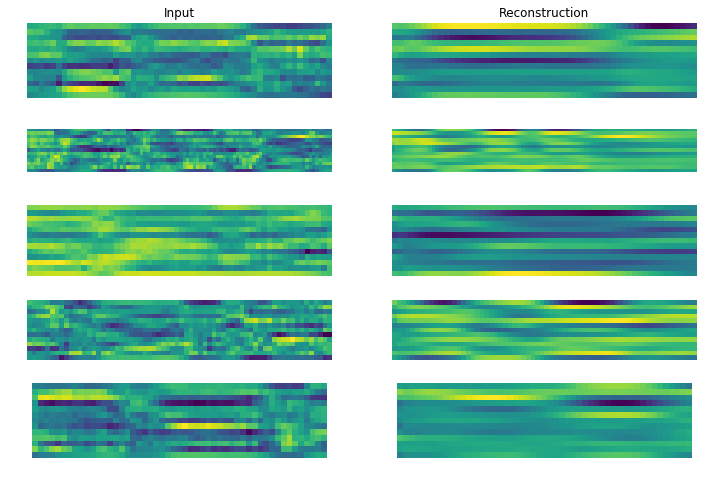

In [20]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

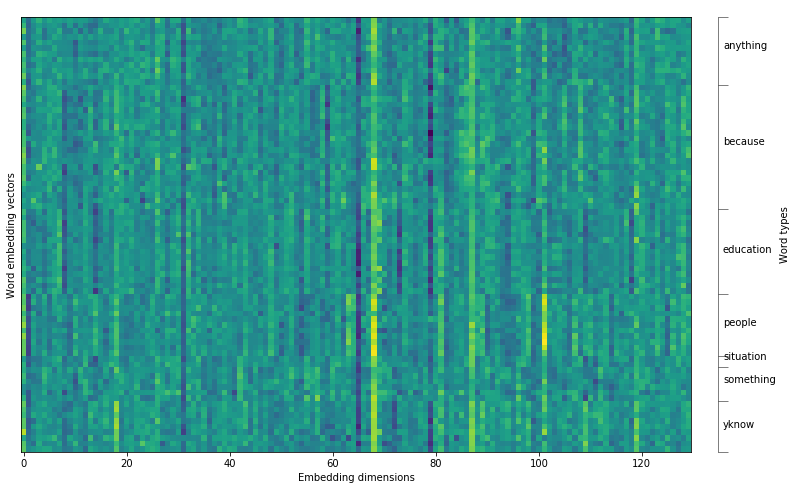

In [21]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )